In [1]:
import numpy
import pymc as pm
import arviz as az
import pandas as pd
import os 
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8924

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.1


In [7]:
behav = pd.read_csv("../dgrpool_ls.tsv", sep='\t')
brain = pd.read_csv("../../Results_Vol_Entropy/macro_meso_140brains.csv")

In [11]:
brain['DGRP'] = brain['DGRP'].apply(lambda x: f'DGRP_{x:03d}' if x < 100 else f'DGRP_{x}')
brain

,Unnamed: 0,DGRP,sex,Entropy0,Entropy1,Entropy2,length,width,height,heightmax,area_sq,area_cube,vol,hull_area,hull_vol,area_ratio,vol_ratio
0,0,DGRP_796,female,1.853573,1.836041,1.908244,134.0,187.0,86.0,90.0,4112647,632441,587521.0,50006.292898,8.037887e+05,82.242589,0.730940
1,1,DGRP_801,male,1.444794,1.658768,1.782129,165.0,141.0,91.0,96.0,4950148,755614,707164.0,50520.468549,9.078440e+05,97.983018,0.778949
2,2,DGRP_195,male,1.931425,1.837035,1.895643,131.0,184.0,84.0,85.0,3555888,550527,507984.0,46253.829949,7.323907e+05,76.877699,0.693597
3,3,DGRP_808,male,1.564583,1.687016,1.807425,171.0,165.0,83.0,101.0,5292196,810582,756028.0,57427.483546,1.042084e+06,92.154412,0.725497
4,4,DGRP_354,male,1.816560,1.665861,1.706493,160.0,133.0,110.0,140.0,3856895,602950,550985.0,48980.075637,8.344605e+05,78.744162,0.660289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,135,DGRP_535,female,1.857803,1.756138,1.806586,81.0,193.0,81.0,85.0,3303055,511510,471865.0,44766.004797,6.798112e+05,73.784896,0.694112
136,136,DGRP_332,female,1.298608,1.398849,1.680942,105.0,115.0,110.0,148.0,2965179,468436,423597.0,37495.569130,5.485598e+05,79.080784,0.772198
137,137,DGRP_486,male,1.359859,1.688593,1.719392,144.0,90.0,132.0,165.0,3049585,485315,435655.0,44058.090766,6.117193e+05,69.217366,0.712181
138,138,DGRP_026,male,1.402470,1.766588,1.886843,144.0,96.0,166.0,166.0,4109847,633355,587121.0,47858.527163,7.961348e+05,85.874916,0.737464


In [8]:
behav

,DGRP,en_s,en_ns,LSM,kl,hell,jsd,centered_kl,centered_hell,centered_jsd
0,DGRP_100,0.297772,0.440423,0.023696,0.097206,0.025995,0.159802,0.069999,0.025303,0.122879
1,DGRP_101,0.385424,0.500993,0.079517,0.039036,0.010253,0.100721,0.065318,0.019456,0.132161
2,DGRP_105,0.390800,0.368535,0.022411,0.143083,0.034725,0.185135,0.119182,0.029048,0.156282
3,DGRP_109,0.231160,0.391669,0.077822,0.136010,0.037262,0.190342,0.076738,0.019975,0.140667
4,DGRP_129,0.366027,0.408072,0.033222,0.029025,0.007739,0.087637,0.034705,0.009444,0.096475
...,...,...,...,...,...,...,...,...,...,...
83,DGRP_897,0.531233,0.434033,0.086866,0.163601,0.036640,0.189203,0.116515,0.025710,0.144439
84,DGRP_091,0.278688,0.292307,-0.074537,0.067456,0.016981,0.129449,0.080570,0.019971,0.134784
85,DGRP_911,0.419133,0.429794,-0.014552,0.051208,0.012643,0.111853,0.045087,0.011314,0.104632
86,DGRP_913,0.364098,0.395188,0.066519,0.055216,0.015600,0.122642,0.043528,0.011273,0.102694


In [13]:
merged_df = pd.merge(brain, behav, on=['DGRP'])

In [14]:
merged_df.columns

Index(['Unnamed: 0', 'DGRP', 'sex', 'Entropy0', 'Entropy1', 'Entropy2',
       'length', 'width', 'height', 'heightmax', 'area_sq', 'area_cube', 'vol',
       'hull_area', 'hull_vol', 'area_ratio', 'vol_ratio', 'en_s', 'en_ns',
       'LSM', 'kl', 'hell', 'jsd', 'centered_kl', 'centered_hell',
       'centered_jsd'],
      dtype='object')

In [18]:
merged_df["Entropy0"] = (zscore(merged_df["Entropy0"]))
merged_df["Entropy1"] = (zscore(merged_df["Entropy1"]))
merged_df["Entropy2"] = (zscore(merged_df["Entropy2"]))
merged_df["Volume"] = (zscore(merged_df["vol"]) )
merged_df["LSM"] = zscore((merged_df["LSM"]))
merged_df["kl"] = zscore((merged_df["kl"]))
merged_df["hell"] = zscore((merged_df["hell"]))
merged_df["jsd"] = zscore((merged_df["jsd"]))

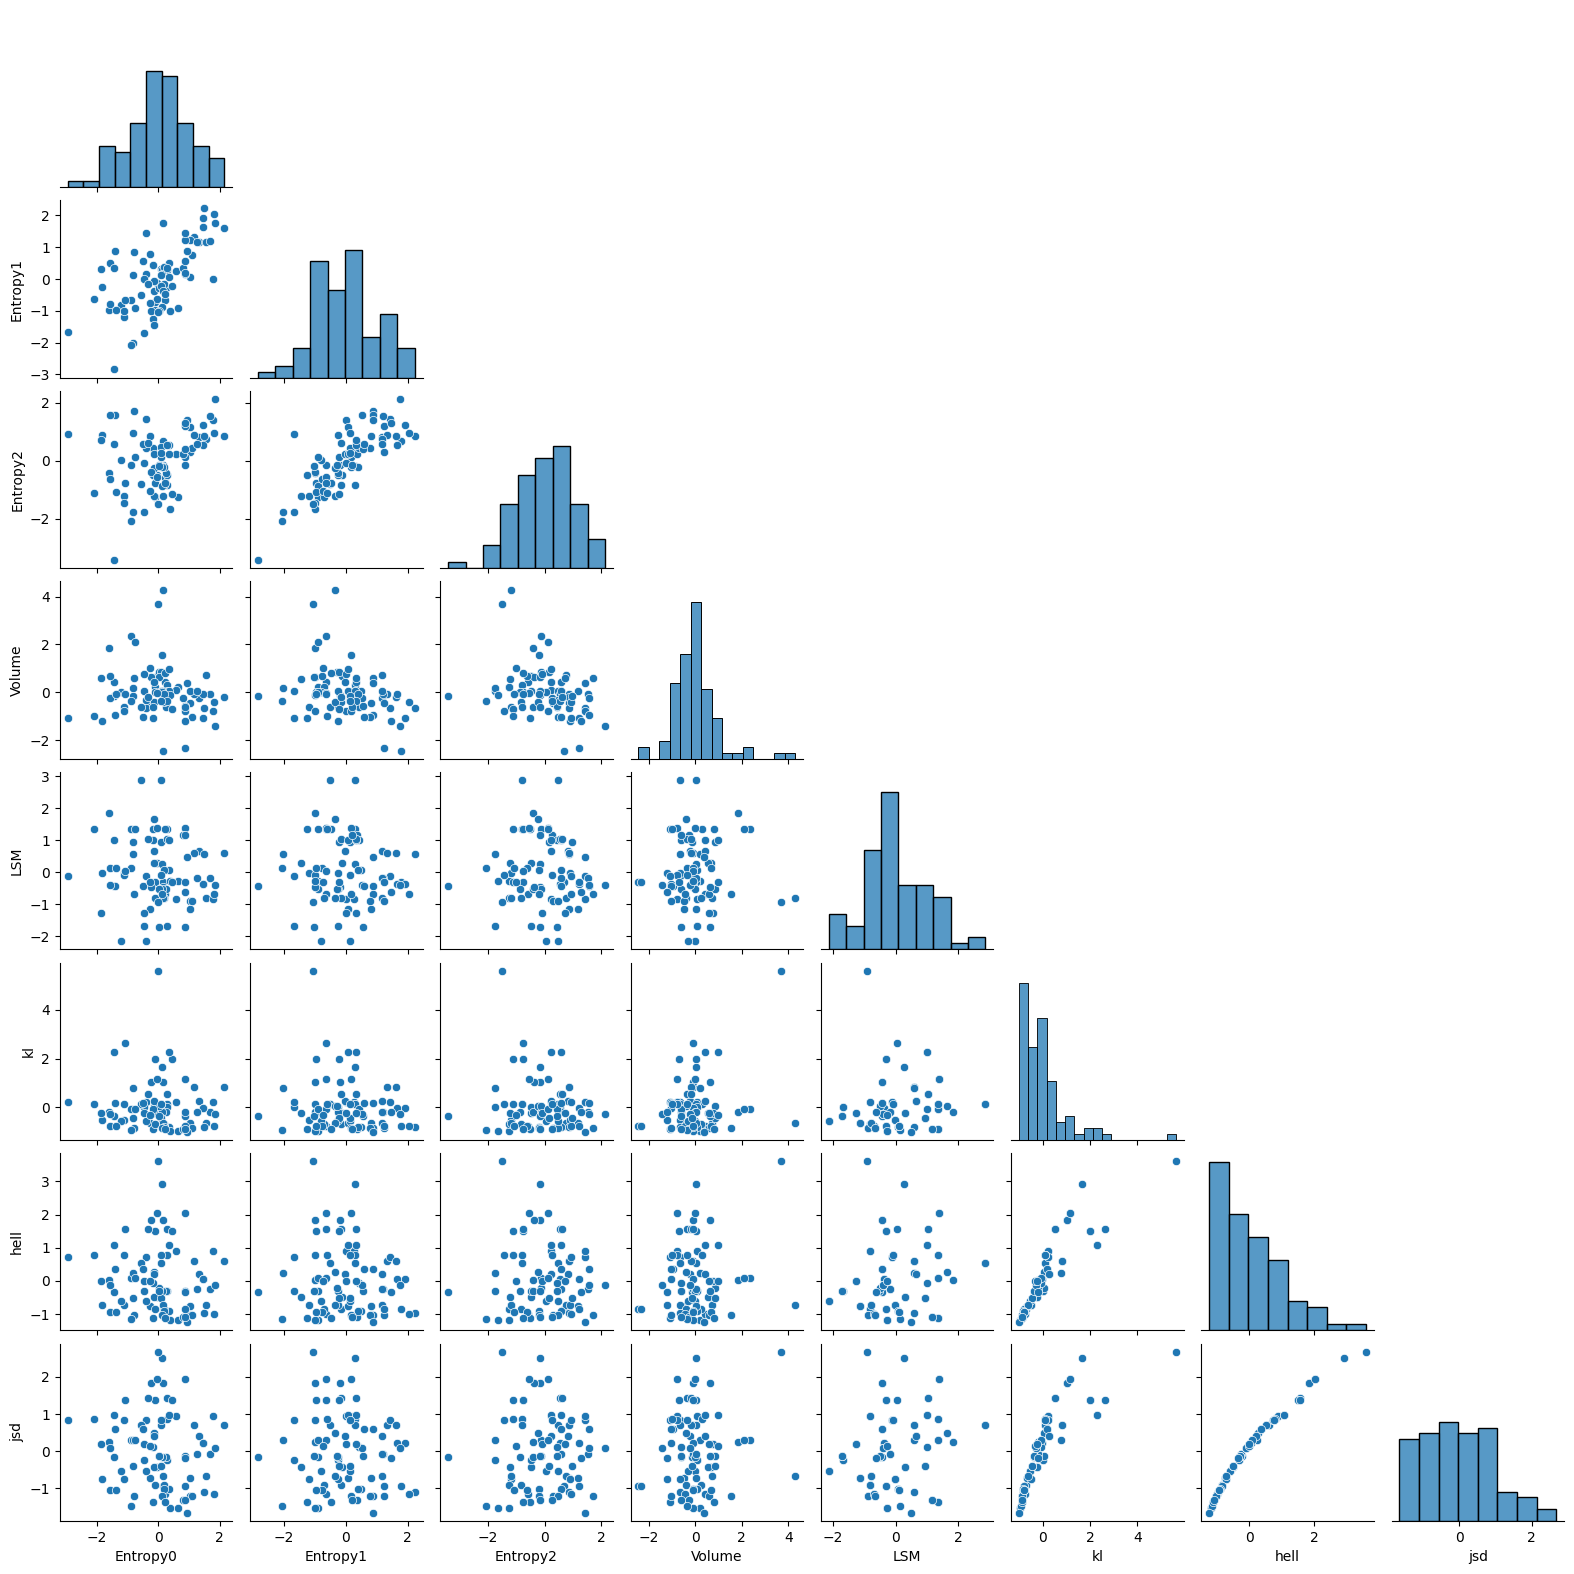

In [20]:
sns.pairplot(merged_df[['Entropy0','Entropy1','Entropy2','Volume','LSM','kl','hell','jsd']],corner=True, height=2)

In [21]:
kl_ls = merged_df['LSM']
E0 = merged_df['Entropy0']
E1 = merged_df['Entropy1']
E2 = merged_df['Entropy2']
Volume = merged_df['Volume']
ls = merged_df['kl']
DGRP, mn_genotype = merged_df.DGRP.factorize()

In [22]:
#coords = {"genotype": mn_genotype}

with pm.Model() as model:
    beta_g = pm.Normal("beta_g", mu=0, sigma=5)
    beta_v = pm.Normal("beta_v", mu=0, sigma=5)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=5)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=5)
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    
    mu = intercept + beta_0 * E0 + beta_1 * E1 + beta_2 * E2 + beta_v * Volume + beta_g * DGRP
    sigma = pm.Exponential("sigma", lam=1)  # Prior for the error term

    # Step 4: Define the likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=ls)


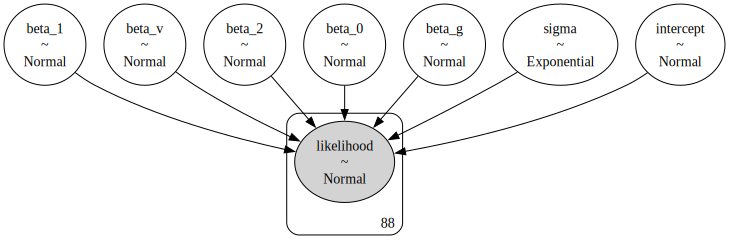

In [23]:
pm.model_to_graphviz(model)

In [24]:
with model:
    trace = pm.sample(3000, tune=10,chains=6, cores=-1,idata_kwargs={"log_likelihood": True} ) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (6 chains in 1 job)
NUTS: [beta_g, beta_v, beta_2, beta_1, beta_0, intercept, sigma]


Output()

Output()

Output()

Output()

Output()

Output()

Sampling 6 chains for 10 tune and 3_000 draw iterations (60 + 18_000 draws total) took 417 seconds.
There were 1441 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_g'}>,
        <Axes: title={'center': 'beta_g'}>],
       [<Axes: title={'center': 'beta_v'}>,
        <Axes: title={'center': 'beta_v'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

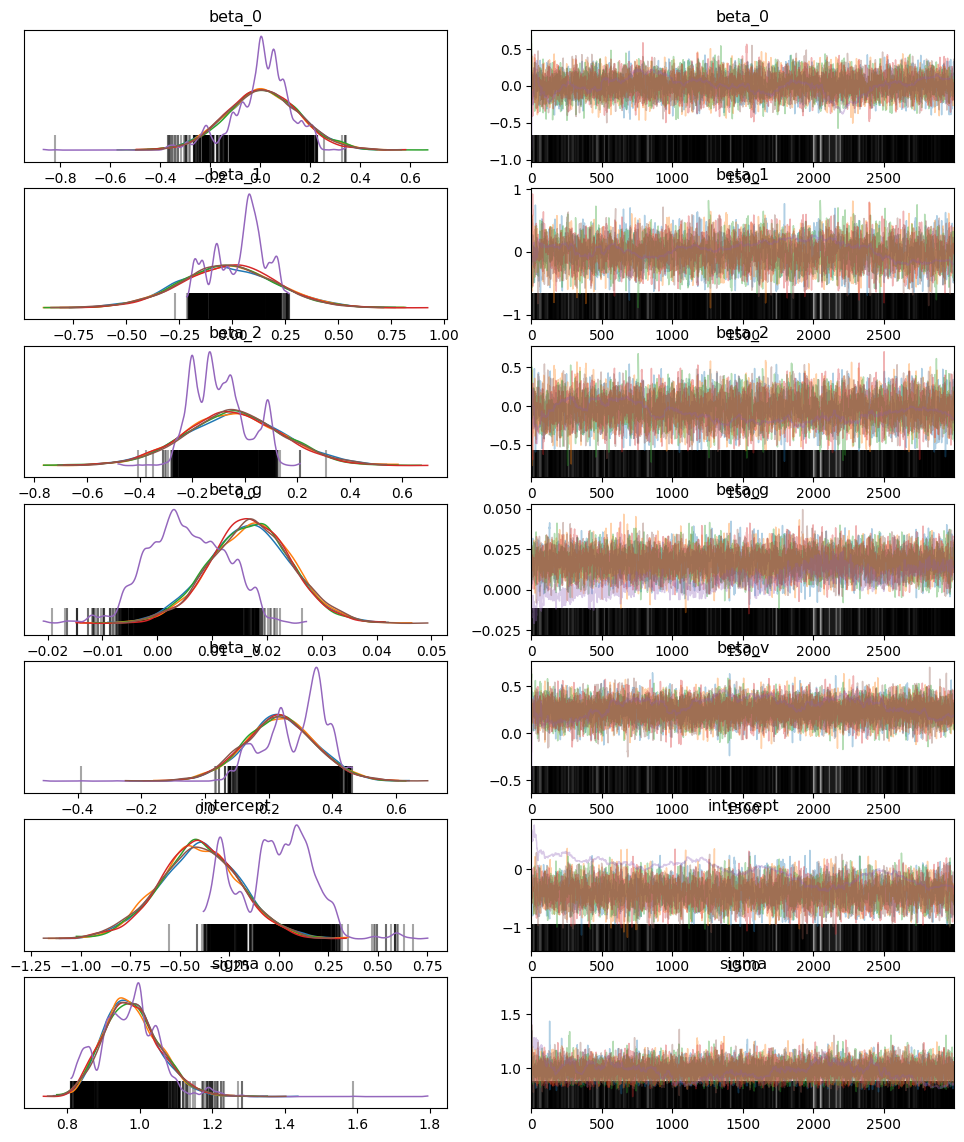

In [25]:
az.plot_trace(trace, compact=False)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

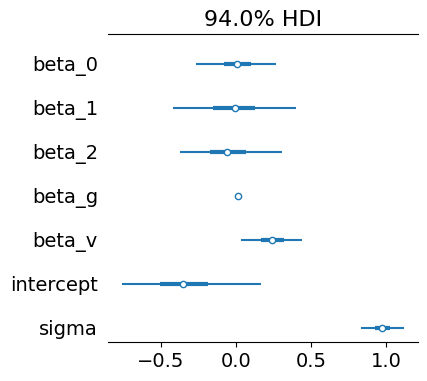

In [26]:
az.plot_forest(trace, figsize=(4,4), combined=True)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_g'}>,
        <Axes: title={'center': 'beta_v'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

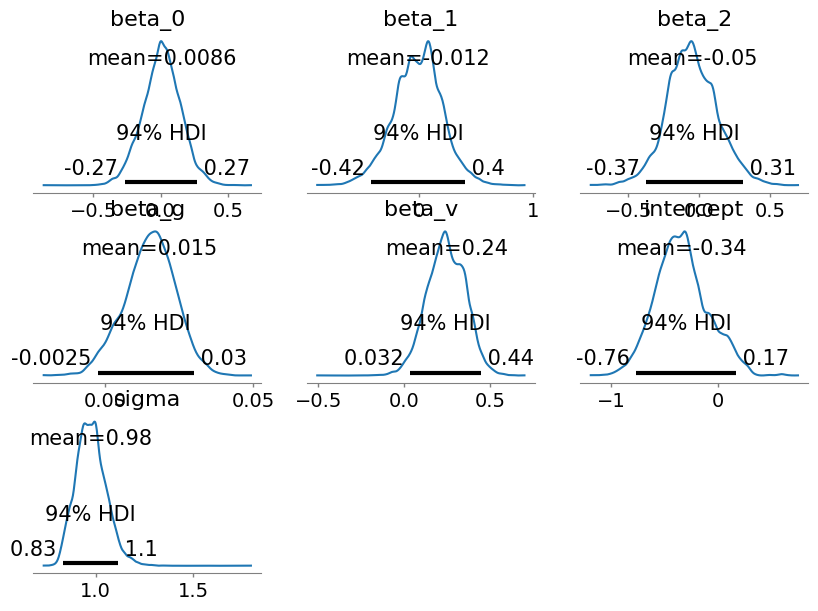

In [27]:
# Extract posterior and intervene on the different entropies
az.plot_posterior(trace, figsize=(10,7))

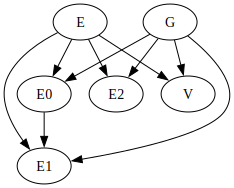

In [28]:
g = gr.Digraph()
g.edge(tail_name='G', head_name='V')
g.edge(tail_name='G', head_name='E0')
g.edge(tail_name='G', head_name='E1')
g.edge(tail_name='G', head_name='E2')
g.edge(tail_name='E', head_name='V')
g.edge(tail_name='E', head_name='E0')
g.edge(tail_name='E', head_name='E1')
g.edge(tail_name='E', head_name='E2')
g.edge(tail_name='E0', head_name='E1')
g


               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean     -0.045159    -0.000437     0.044722
std       1.049481     1.043663     1.386858
min      -3.120942    -3.391416    -3.954545
25%      -0.772061    -0.729277    -0.874857
50%      -0.012138    -0.042085     0.074273
75%       0.678265     0.654618     0.971839
max       3.234326     3.010695     4.384462


Text(0.5, 1.0, 'Do Entropy0')

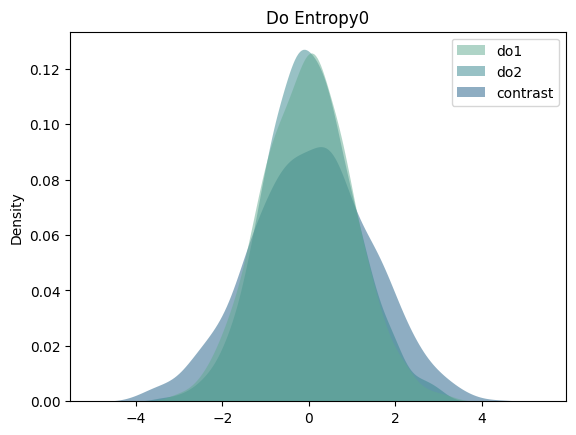

In [29]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * 0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v + beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * 1 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy0')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.017452    -0.354225    -0.371676
std       1.084476     1.032949     1.384601
min      -3.378743    -3.824360    -4.480378
25%      -0.694388    -1.057641    -1.314271
50%       0.000028    -0.302013    -0.379745
75%       0.771710     0.293250     0.604646
max       2.902397     3.019090     4.266573


Text(0.5, 1.0, 'Do Entropy1')

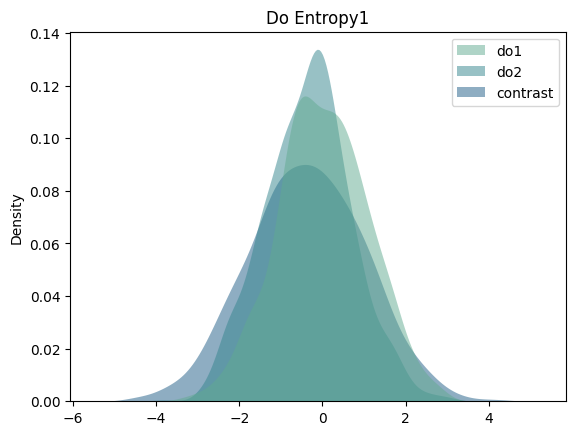

In [362]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * 0 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * 1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy1')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean     -0.002272     0.291227     0.293499
std       1.115750     1.085834     1.385301
min      -3.746187    -3.471684    -4.158170
25%      -0.781593    -0.439859    -0.624769
50%       0.007082     0.308646     0.267959
75%       0.738161     0.990711     1.247329
max       3.449556     3.586072     5.009918


Text(0.5, 1.0, 'Do Entropy2')

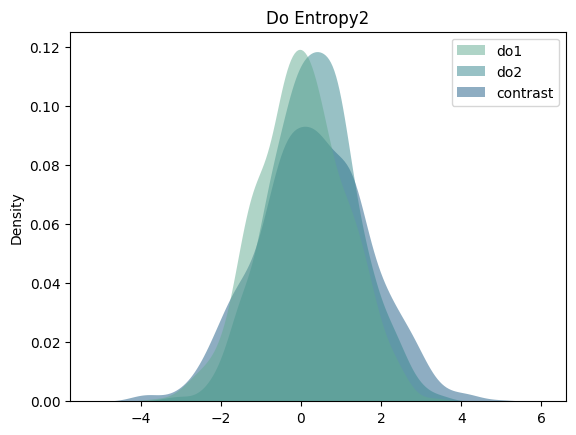

In [363]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * 0 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * 1 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy2')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.019513    -0.183446    -0.202960
std       1.125630     1.132043     1.459029
min      -3.132056    -4.420540    -4.802542
25%      -0.789441    -0.927583    -1.214006
50%      -0.000449    -0.222164    -0.180213
75%       0.807153     0.578754     0.778583
max       3.245865     4.107475     4.601011


Text(0.5, 1.0, 'Do Volume')

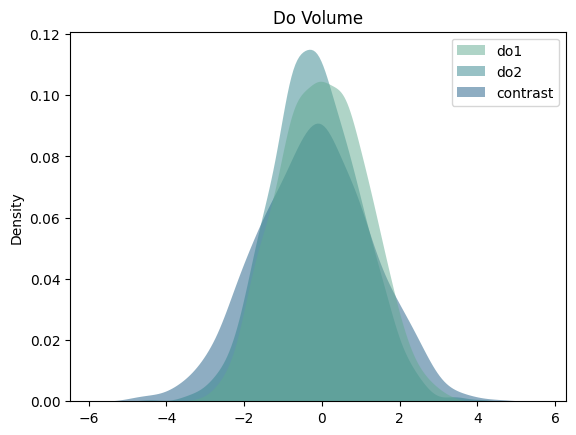

In [364]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * 0+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * 1+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Volume')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.029455     0.021775    -0.007681
std       1.122545     1.140246     1.492641
min      -4.130890    -4.210274    -5.979985
25%      -0.735729    -0.721945    -1.028850
50%       0.021818     0.048128    -0.030288
75%       0.802162     0.706820     0.967971
max       4.128719     4.358327     6.855740


Text(0.5, 1.0, 'Do Genotype')

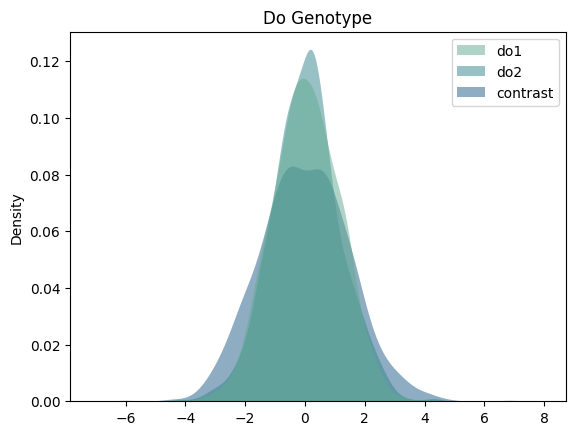

In [365]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * 0, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * 1, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Genotype')